<h1><center>Model UC defect points equations</center></h1>

<h2>Imports and helper functions</h2>

In [42]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [43]:
#Contans
pi = np.pi
kb = 8.617333262145e-5  # Boltzmann constant in eV/K
T = 600 + 273.15        # Temperature in Kelvin
filename = "../../data/UC-UN/UC-diameter-density.csv"

In [44]:
# Helper functions
def D_Coeff(D_0, E_m, T):
    """Calculate diffusion coefficient."""
    return D_0 * np.exp(-E_m / (kb * T))

def log_factor(r_0, r_L):
    """Calculate the logarithmic factor for flux."""
    logt = np.log(8 * r_L / r_0)
    r = r_0 * logt
    return 1 / r 

def compute_j_L_i(C_U_i, C_C_i, D_U_i, D_C_i, r_0, r_L):
    """Calculate interstitial flux."""
    log_fact = log_factor(r_0, r_L)
    num = D_U_i * C_U_i * D_C_i * C_C_i
    den = D_U_i * C_U_i + D_C_i * C_C_i
    return log_fact * num / den 

def compute_j_L_v(C_U_v, C_C_v, D_U_v, D_C_v, r_0, r_L):
    """Calculate vacancy flux."""
    log_fact = log_factor(r_0, r_L)
    num = D_U_v * C_U_v * D_C_v * C_C_v
    den = D_U_v * C_U_v + D_C_v * C_C_v
    return log_fact * num / den 

def compute_j_ii(C_U_i, C_C_i, D_U_i, D_C_i):
    """Calculate interstitial-interstitial annihilation flux."""
    num = D_U_i * (C_U_i**2) * D_C_i * (C_C_i**2)
    den = D_U_i * (C_U_i**2) + D_C_i * (C_C_i**2)
    return num / den 

def loop_life_time_term(N_L, R_L, alpha, beta, k_lf):
    """Calculate the loop lifetime term."""
    return k_lf * (N_L**alpha) * (R_L**beta)

In [45]:
def load_uc_datasets(filename: str):
    # Read CSV file, skipping first row (dataset names row)
    df = pd.read_csv(filename, skiprows=1)

    # Temperature mapping
    temp_map_uc = {
        '300': '300°C',
        '600': '600°C'
    }

    datasets_uc = {}

    # Column mapping
    temperatures = ['300', '600']
    density_cols = [0, 2]   # X columns for density data
    diameter_cols = [4, 6]  # X columns for diameter data

    # Helper function to extract one dataset into DataFrame
    def extract_dataframe(x_col, y_col, label):
        x_data = pd.to_numeric(df.iloc[:, x_col], errors='coerce').dropna()
        y_data = pd.to_numeric(df.iloc[:, y_col], errors='coerce').dropna()
        min_len = min(len(x_data), len(y_data))
        if min_len == 0:
            return None
        
        x_vals = x_data.iloc[:min_len].values
        y_vals = y_data.iloc[:min_len].values
        
        sorted_idx = np.argsort(x_vals)
        x_sorted = x_vals[sorted_idx]
        y_sorted = y_vals[sorted_idx]
        
        return pd.DataFrame({
            "X": x_sorted,
            "Y": y_sorted,
            "temp": temp_map_uc[label]
        })

    # Extract density datasets
    for i, temp in enumerate(temperatures):
        result = extract_dataframe(density_cols[i], density_cols[i] + 1, temp)
        if result is not None:
            datasets_uc[f"density_uc_{temp}"] = result

    # Extract diameter datasets
    for i, temp in enumerate(temperatures):
        result = extract_dataframe(diameter_cols[i], diameter_cols[i] + 1, temp)
        if result is not None:
            datasets_uc[f"diameter_uc_{temp}"] = result

    return datasets_uc


<h3>Plotting function</h3>

In [73]:
def interactive_plots(results, G_0):
    time = results['time']
    dose = time * G_0

    # Ce Concentrations
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=time, y=results['C_U_v'],
                              mode='lines', name='C<sub>U<sub>v<sub><sub>'))
    fig1.add_trace(go.Scatter(x=time, y=results['C_U_i'],
                              mode='lines', name='C<sub>U<sub>i<sub><sub>'))
    fig1.update_layout(title="Vacancy Concentrations",
                       xaxis=dict(title="Time [s]", type="log",  exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig1.show()

    # O Concentrations
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=time, y=results['C_C_v'],
                              mode='lines', name='C<sub>C<sub>v<sub><sub>'))
    fig2.add_trace(go.Scatter(x=time, y=results['C_C_i'],
                              mode='lines', name='C<sub>C<sub>i<sub>sub>'))
    fig2.update_layout(title="Interstitial Concentrations",
                       xaxis=dict(title="Time [s]", type="log", exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig2.show()

    # Loop density
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=dose, y=results['N_L']*1e-15,
                              mode='lines', name='N_L'))
    fig3.update_layout(title="Dislocation Loop Density",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Density [ 10<sup>15</sup> cm<sup>-3</sup>] "),
                       width=600, height=500)
    fig3.show()

    # Loop radius
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=dose, y=results['R_L']*1e7,
                              mode='lines', name='R_L'))
    fig4.update_layout(title="Dislocation Loop Radius",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Radius [nm]"),
                       width=600, height=500)
    fig4.show()

<h2>ODE System</h2>

In [74]:
# ODE system for U and C
def ODE_system(t, y, params):
    C_U_v, C_C_v, C_U_i, C_C_i, N_L, R_L = y

    # Parameters
    G_U_v = params['G_U_v']
    G_C_v = params['G_C_v']
    G_U_i = params['G_U_i']
    G_C_i = params['G_C_i']
    a     = params['a']
    Omega_0 = (a**3) /4
    D_U_i = params['D_U_i']
    D_C_i = params['D_C_i']
    D_U_v = params['D_U_v']
    D_C_v = params['D_C_v']
    r0    = params['r0']
    b     = a / np.sqrt(3)
    alpha = params['alpha']
    beta  = params['beta']
    k_lf  = params['k_lf']

    
    eta   = Omega_0 / a**2
    st    = 2 * pi * R_L * N_L

    # Currents
    j_L_i = 0
    j_L_v = 0
    j_ii = 0
    
    if C_U_i != 0 and C_C_i != 0:
        j_L_i = compute_j_L_i(C_U_i, C_C_i, D_U_i, D_C_i, r0, R_L)
        j_L_v = compute_j_L_v(C_U_v, C_C_v, D_U_v, D_C_v, r0, R_L)
        j_ii  = compute_j_ii(C_U_i, C_C_i, D_U_i, D_C_i)
        if j_L_i - j_L_v <= 0:
            j_L_i = j_L_v = 0
    
    # Loop lifetime term
    tau = loop_life_time_term(N_L, R_L, alpha, beta, k_lf)
    
    # Reaction rates
    k_U = eta * (24 * D_U_i + 36 * D_U_v)
    k_C = eta * (24 * D_C_i + 36 * D_C_v)

    # Differential equations
    dc = np.zeros(6)

    # N_L evolution
    dc[4] = 30 * eta * j_ii 
    
    if tau != 0:
        dc[4] -= N_L / tau

    # R_L evolution
    dc[5] = (2 * Omega_0) * (2 * pi * r0 / b) * (j_L_i - j_L_v) - (R_L/(2 * N_L)) * dc[4]

    if dc[5] < 0 and R_L <= 2 * r0:
        dc[5] = 0
        
    if dc[4] < 0 and N_L <= 0:
        dc[4] = 0

    # Vacancy and interstitial concentrations
    dc[0] = G_U_v - k_U * C_U_v * C_U_i - pi * r0 * j_L_v * st #C_U_v
    dc[1] = G_C_v - k_C * C_C_v * C_C_i - pi * r0 * j_L_v * st #C_C_v
    dc[2] = G_U_i - k_U * C_U_i * C_U_v - pi * r0 * j_L_i * st - 30 * eta * j_ii #C_U_i
    dc[3] = G_C_i - k_C * C_C_i * C_C_v - j_L_i * pi * r0 * st - 30 * eta * j_ii #C_U_i

    return dc

<h2>Fit function</h2>

In [75]:
def fit_function(E_U_i, E_C_v, E_C_i, k_lf,
                 dose_exp_R, dose_exp_N, y0, t_span, ode_params, G_0, t_eval):
    """
    Returns concatenated model predictions for R_L and N_L 
    at doses corresponding to experimental data.
    """
    # Diffusion prefactors
    D_0_U_i, D_0_U_v, D_0_C_i, D_0_C_v = 0.1, 0.1, 0.1, 0.1
    E_U_v = 5.0 #eV fixed

    ode_params['D_U_i'] = D_Coeff(D_0_U_i, E_U_i, T)
    ode_params['D_U_v'] = D_Coeff(D_0_U_v, E_U_v, T)
    ode_params['D_C_i'] = D_Coeff(D_0_C_i, E_C_i, T)
    ode_params['D_C_v'] = D_Coeff(D_0_C_v, E_C_v, T)
    ode_params['k_lf']  = k_lf

    sol = solve_ivp(
        ODE_system, t_span, y0, args=(ode_params,),
        method="BDF", t_eval=t_eval, rtol=1e-6, atol=1e-9
    )
    
    if not sol.success:
        return np.full(len(dose_exp_R) + len(dose_exp_N), np.nan)

    dose_model = sol.t * G_0

    # Interpolate model onto experimental dose points
    R_model = np.interp(dose_exp_R, dose_model, sol.y[5, :])  # R_L
    N_model = np.interp(dose_exp_N, dose_model, sol.y[4, :])  # N_L

    return np.concatenate([R_model, N_model])

<h2>Doing the fit</h2>
<h3>Defining parameters</h3>

In [76]:
# Parameters
a = 488e-10   # cm
N = 4
Omega_0 = (a**3) / N
b = a / np.sqrt(3)

# Diffusion coefficients and migration energies for U and C
D_0_U_v, D_0_U_i, D_0_C_v, D_0_C_i = 0.1, 0.1, 0.1, 0.1


# Dose rate dpa/s
G_0 = 8.75e-6
# Ratio of U to C

G_tot = G_0 / Omega_0
G_U = G_tot 
G_C = G_U 

# Initial conditions
t0 = 0.0001149
y0 = [G_U * t0, G_C * t0, G_U * t0, G_C * t0, G_C * t0 * 1e-6, np.sqrt(N * Omega_0 / (pi * b))]

# Total time from total dose
G_0 = 8.75e-6
dmg = 3.0   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 3000)

ode_params = {
    'G_U_v': G_U, 'G_C_v': G_C,
    'G_U_i': G_U, 'G_C_i': G_C,
    'a': a,
    'D_0_U_i': D_0_U_i,
    'D_0_U_v': D_0_U_v,
    'D_0_C_i': D_0_C_i,
    'D_0_C_v': D_0_C_v,
    'r0': 4 * a,  
    'alpha': 1,    
    'beta': 1,     
    'k_lf': 1.0    
}


In [77]:
# Load datasets
datasets_uc = load_uc_datasets("../../data/UC-UN/UC-diameter-density.csv")

# Pick 600°C datasets
data_R = datasets_uc["diameter_uc_600"]  # radius
data_N = datasets_uc["density_uc_600"]   # density

dose_exp_R = data_R["X"].values
R_exp      = data_R["Y"].values*1e-7

dose_exp_N = data_N["X"].values
N_exp      = data_N["Y"].values*1e21*1e-6




In [78]:
# Initial conditions
t0 = 0.01149
y0 = [G_U * t0, G_C * t0, G_U * t0, G_C * t0, G_C * t0 * 1e-6, np.sqrt(N * Omega_0 / (pi * b))]

# Combine experimental data into one array
data_all = np.concatenate([R_exp, N_exp])

data_all = data_all 

In [79]:
# Initial guess and bounds
p0 = [1.0, 1.0, 1.0, 1.0]  # [E_U_i, E_C_v, E_C_i, k_lf]
bounds = ([0.1, 0.1, 0.1, 0.0], [5.0, 5.0, 5.0, 10e12])

# Perform fit
popt, pcov = curve_fit(
    lambda _, E_U_i, E_C_v, E_C_i, k_lf: fit_function(
        E_U_i, E_C_v, E_C_i, k_lf,
        dose_exp_R, dose_exp_N, y0, t_span, ode_params.copy(), G_0, t_eval
    ),
    xdata=np.zeros_like(data_all),
    ydata=data_all,
    p0=p0,
    bounds=bounds
)


print("Best fit parameters:")
print(f"E_U_v = 5 eV - fixed")
print(f"E_U_i = {popt[0]:.3f} eV")
print(f"E_C_v = {popt[1]:.3f} eV")
print(f"E_C_i = {popt[2]:.3f} eV")
print(f"k_lf  = {popt[3]:.3e}")


Best fit parameters:
E_U_v = 5 eV - fixed
E_U_i = 0.970 eV
E_C_v = 0.970 eV
E_C_i = 0.974 eV
k_lf  = 1.360e+01


In [80]:
# Update params with best fit
ode_params_fit = ode_params.copy()
ode_params_fit['D_U_v'] = D_Coeff(0.1, 5, T)
ode_params_fit['D_U_i'] = D_Coeff(0.1, popt[0], T)
ode_params_fit['D_C_i'] = D_Coeff(0.1, popt[1], T)
ode_params_fit['D_C_v'] = D_Coeff(0.1, popt[2], T)
ode_params_fit['k_lf']  = popt[3]

# Solve ODE again
sol_fit = solve_ivp(
    ODE_system, t_span, y0, args=(ode_params_fit,),
    method="BDF", t_eval=t_eval, rtol=1e-6, atol=1e-9
)

results = {
    'time': sol_fit.t,
    'C_U_v': sol_fit.y[0],
    'C_U_i': sol_fit.y[2],
    'C_C_v': sol_fit.y[1],
    'C_C_i': sol_fit.y[3],
    'N_L': sol_fit.y[4],
    'R_L': sol_fit.y[5]
}

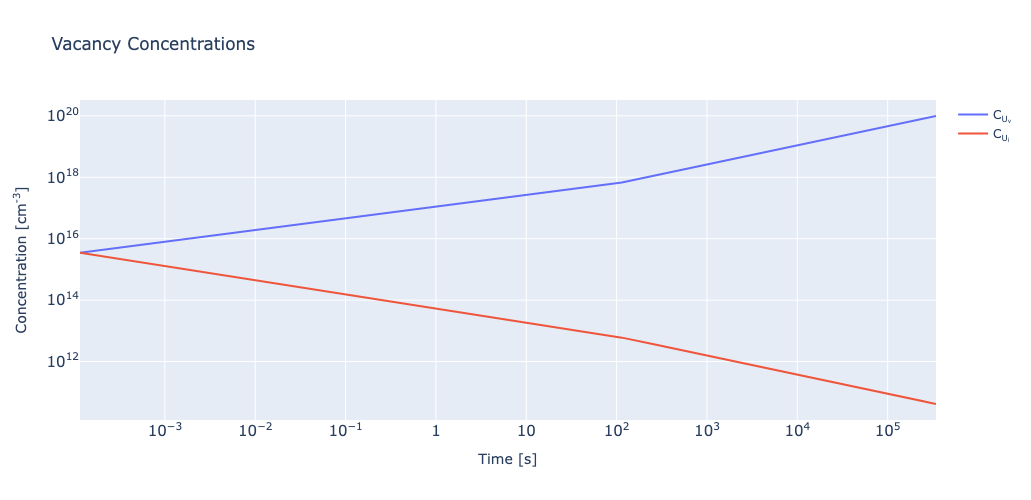

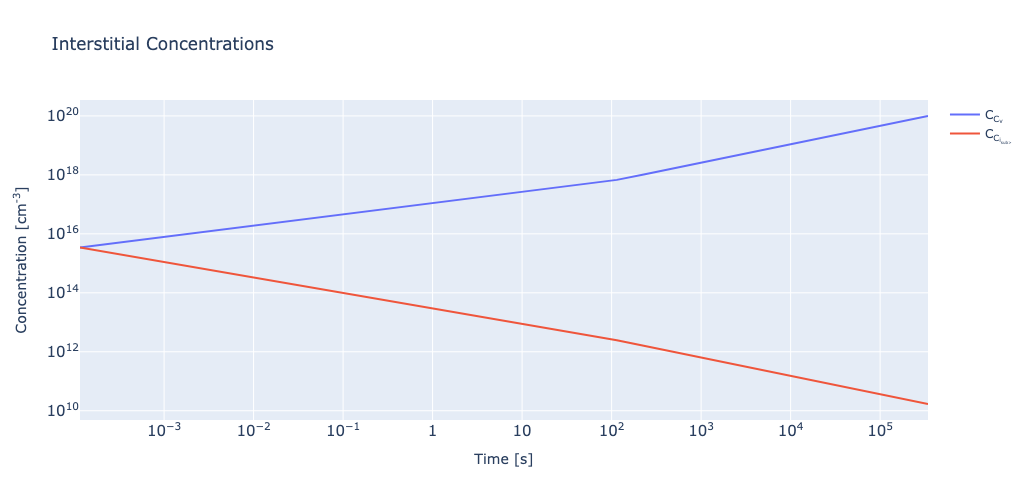

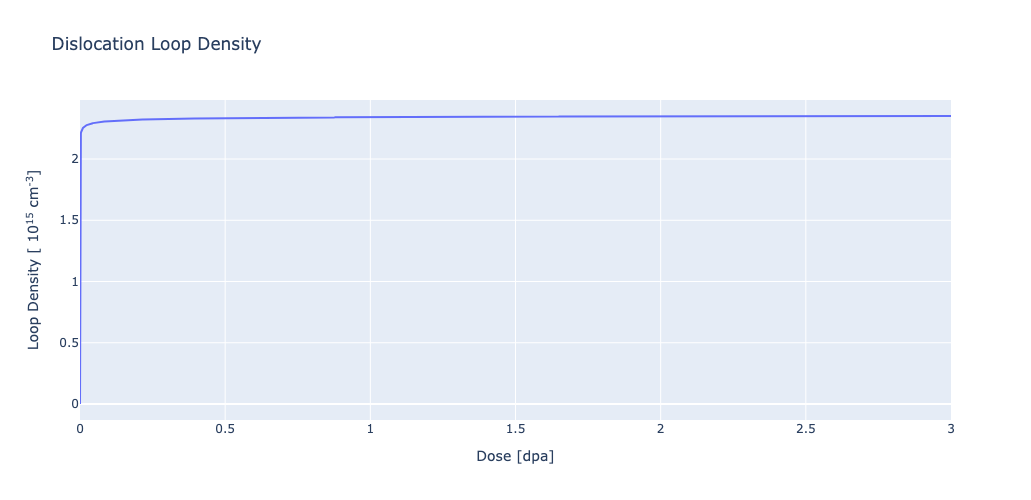

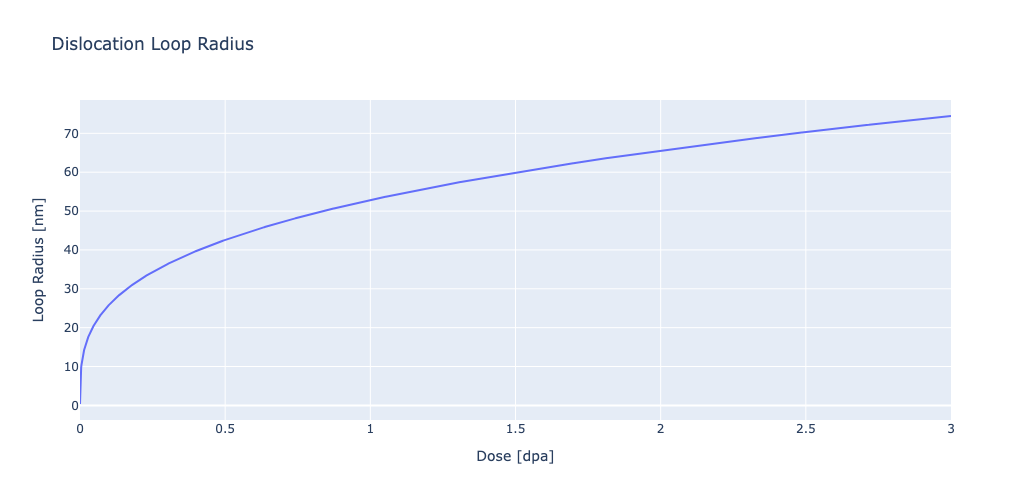

In [81]:
# Interactive plots of full ODE solution
interactive_plots(results, G_0)

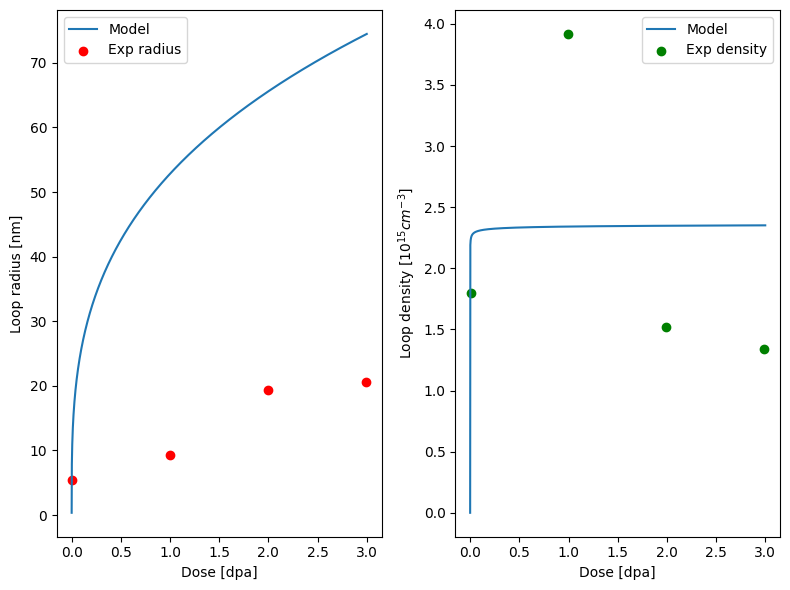

In [82]:
# Overlay experimental points
dose_model = sol_fit.t * G_0
plt.figure(figsize=(8,6))

# Radius
plt.subplot(1,2,1)
plt.plot(dose_model, results['R_L']*1e7, label="Model")  # radius nm
plt.scatter(dose_exp_R, R_exp*1e7, color="red", label="Exp radius")
plt.xlabel("Dose [dpa]"); plt.ylabel("Loop radius [nm]")
plt.legend()

# Density
plt.subplot(1,2,2)
plt.plot(dose_model, results['N_L']*1e-15, label="Model")  # density
plt.scatter(dose_exp_N, N_exp*1e-15, color="green", label="Exp density")
plt.xlabel("Dose [dpa]"); plt.ylabel("Loop density [$10^{15} cm^{-3}$]")
plt.legend()

plt.tight_layout()
plt.show()